## Подготовка

In [1]:
!pip install --upgrade lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline   

In [67]:
!pip freeze > requirements.txt

In [3]:
import warnings

# Отключаем FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Отключаем научную нотацию в pandas
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
#Сколько строк загружать из датафреймов
DF_LEN = 10**9

RANDOM_STATE = 42

In [5]:
# Функция загрузки файлов
def load_csv(path):
    try:
        df = pd.read_csv(path, nrows=DF_LEN)
        print(path, ' загружен успешно.')
        return df
    except Exception as e:
        print(f'Ошибка при загрузке {path}: {e}')
        return None

In [6]:
# Функция анализа датафрейма
def info(df):
    display(df.head())
    print(f"Дубликатов: ", df.duplicated().sum())
    print('Всего записей, колонок', df.shape)
    display(pd.DataFrame({
        'Колонка': df.columns,
        'Тип данных': df.dtypes.values,
        'Пропуски': df.isna().sum(),
    }).reset_index(drop=True))

In [7]:
# Функция приведения типа к дате
def to_datetime64(df, cols, format):
    for col in cols:
        df[col] = pd.to_datetime(df[col], format=format, errors='coerce')

## EDA

### Сообщения

In [8]:
messages = load_csv('./filtered_data/apparel-messages.csv')

./filtered_data/apparel-messages.csv  загружен успешно.


In [9]:
info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Дубликатов:  48610
Всего записей, колонок (12739798, 7)


,Колонка,Тип данных,Пропуски
0,bulk_campaign_id,int64,0
1,client_id,int64,0
2,message_id,object,0
3,event,object,0
4,channel,object,0
5,date,object,0
6,created_at,object,0


In [10]:
messages = messages.drop_duplicates()

In [11]:
to_datetime64(messages, ['date'], '%Y-%m-%d')
to_datetime64(messages, ['created_at'], '%Y-%m-%d %H:%M:%S')

In [12]:
print(messages['channel'].value_counts())

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64


In [13]:
print(messages['event'].value_counts())

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64


In [14]:
print('Записей в messages до: ', len(messages))
messages = messages[messages['event'].isin([
    'open',
    'click',
    'purchase',
    'subscribe',
    'unsubscribe',
    'complain'
    ])]
print('Записей в messages после: ', len(messages))

Записей в messages до:  12691188
Записей в messages после:  3601845


In [15]:
messages = messages.drop(columns=['date'])

In [16]:
info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19 00:56:52


Дубликатов:  0
Всего записей, колонок (3601845, 6)


,Колонка,Тип данных,Пропуски
0,bulk_campaign_id,int64,0
1,client_id,int64,0
2,message_id,object,0
3,event,object,0
4,channel,object,0
5,created_at,datetime64[ns],0


### Покупки

In [17]:
purchases = load_csv('./filtered_data/apparel-purchases.csv')

./filtered_data/apparel-purchases.csv  загружен успешно.


In [18]:
info(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Дубликатов:  73020
Всего записей, колонок (202208, 6)


,Колонка,Тип данных,Пропуски
0,client_id,int64,0
1,quantity,int64,0
2,price,float64,0
3,category_ids,object,0
4,date,object,0
5,message_id,object,0


In [19]:
to_datetime64(purchases, ['date'], '%Y-%m-%d')

In [20]:
purchases['price'] = purchases['price'].astype(str).str.replace(',', '', regex=False)
purchases['price'] = pd.to_numeric(purchases['price'], errors='coerce').astype('Int64')

In [21]:
latest_date = purchases['date'].max()
purchases['n_days'] = (latest_date - purchases['date']).dt.days

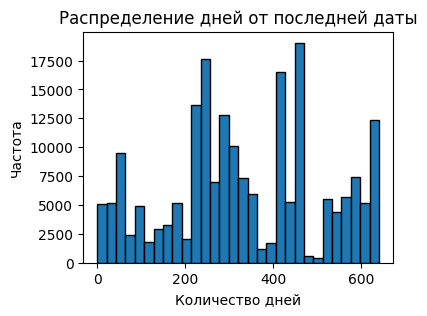

In [22]:
plt.figure(figsize=(4, 3))

plt.hist(purchases['n_days'], bins=30, edgecolor='black')
plt.title('Распределение дней от последней даты')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

In [23]:
print(purchases['price'].sort_values(ascending=True))

107691        1
81608         1
81607         1
81606         1
81605         1
          ...  
171436    52999
138818    53499
166578    60200
166576    63499
186736    85499
Name: price, Length: 202208, dtype: Int64


In [24]:
Q1 = purchases['price'].quantile(0.25)
Q3 = purchases['price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

purchases = purchases[purchases['price'] <= upper_bound]

count   195,619
mean      1,045
std         853
min           1
25%         338
50%         901
75%       1,539
max       3,713
Name: price, dtype: Float64


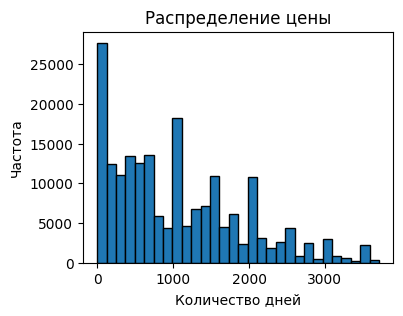

In [25]:
print(purchases['price'].describe())

plt.figure(figsize=(4, 3))

plt.hist(purchases['price'], bins=30, edgecolor='black')
plt.title('Распределение цены')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

In [26]:
print(purchases['quantity'].value_counts())

quantity
1     194767
2        724
3         88
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64


count   195,619
mean      1,045
std         731
min           1
25%         461
50%         910
75%       1,499
max       3,713
Name: avg_check, dtype: Float64


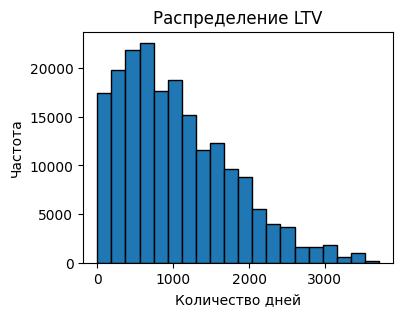

In [27]:
# Добавим средний чек
purchases.loc[:, 'avg_check'] = purchases.groupby('client_id')['price'].transform('mean')

print(purchases['avg_check'].describe())

plt.figure(figsize=(4, 3))

plt.hist(purchases['avg_check'], bins=20, edgecolor='black')
plt.title('Распределение LTV')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

count   195,619
mean      8,853
std      14,422
min           1
25%       2,398
50%       5,038
75%      10,096
max     222,996
Name: ltv, dtype: Float64


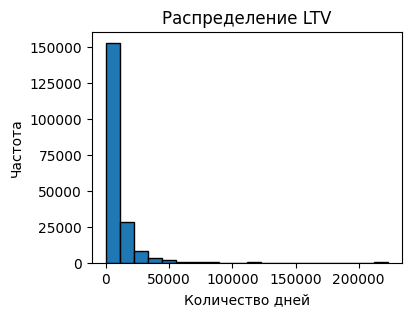

In [28]:
# Добавим LTV
purchases.loc[:, 'ltv'] = purchases.groupby('client_id')['price'].transform('sum') #ltv

print(purchases['ltv'].describe())

plt.figure(figsize=(4, 3))

plt.hist(purchases['ltv'], bins=20, edgecolor='black')
plt.title('Распределение LTV')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

In [29]:
# Добавим среднее количество дней между покупками (если покупа одна, укажем 0)
purchases_unique = (purchases
                    .drop_duplicates(subset=['client_id', 'date'])
                    .sort_values(by=['client_id', 'date']))

# Рассчитываем разницу в днях между покупками для каждого client_id
purchases_unique['days_diff'] = purchases_unique.groupby('client_id')['date'].diff().dt.days

# Рассчитываем среднее количество дней между покупками для каждого client_id
average_intervals = purchases_unique.groupby('client_id')['days_diff'].mean()

# Записываем результат обратно в purchases
purchases.loc[:, 'purchase_interval'] = purchases['client_id'].map(average_intervals)
purchases['purchase_interval'] = purchases['purchase_interval'].fillna(0)

count   195,619
mean         31
std          76
min           0
25%           0
50%           0
75%           5
max         619
Name: purchase_interval, dtype: float64


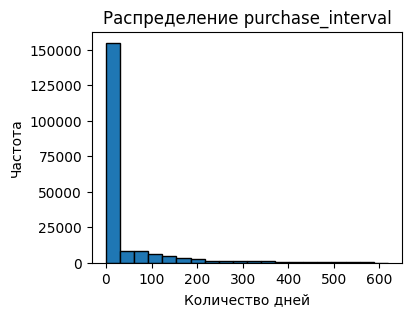

In [30]:
print(purchases['purchase_interval'].describe())

plt.figure(figsize=(4, 3))

plt.hist(purchases['purchase_interval'], bins=20, edgecolor='black')
plt.title('Распределение purchase_interval')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

In [31]:
purchases['category_0'] = purchases['category_ids'].str.strip('[]').str.split(', ').str[0].str.strip("'")
purchases['category_-1'] = purchases['category_ids'].str.strip('[]').str.split(', ').str[-1].str.strip("'")

In [32]:
info(purchases)

,client_id,quantity,price,category_ids,date,message_id,n_days,avg_check,ltv,purchase_interval,category_0,category_-1
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431
5,1515915625471640575,1,3499,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,641,"1,774",7096,32,2,441
6,1515915625490211585,1,1699,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,641,"1,699",1699,0,2,1311
7,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,641,"1,999",1999,0,2,451


Дубликатов:  70966
Всего записей, колонок (195619, 12)


,Колонка,Тип данных,Пропуски
0,client_id,int64,0
1,quantity,int64,0
2,price,Int64,0
3,category_ids,object,0
4,date,datetime64[ns],0
5,message_id,object,0
6,n_days,int64,0
7,avg_check,Float64,0
8,ltv,Int64,0
9,purchase_interval,float64,0


### Целевой признак

In [33]:
target_binary = load_csv('./filtered_data/apparel-target_binary.csv')

./filtered_data/apparel-target_binary.csv  загружен успешно.


In [34]:
info(target_binary)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Дубликатов:  0
Всего записей, колонок (49849, 2)


,Колонка,Тип данных,Пропуски
0,client_id,int64,0
1,target,int64,0


In [35]:
print(target_binary['target'].value_counts())

target
0    48888
1      961
Name: count, dtype: int64


### Доп. датафреймы

In [36]:
#Агрегация по дням с учетом событий и каналов рассылки
events_channel = load_csv('./filtered_data/full_campaign_daily_event_channel.csv')

./filtered_data/full_campaign_daily_event_channel.csv  загружен успешно.


In [37]:
info(events_channel)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Дубликатов:  0
Всего записей, колонок (131072, 36)


,Колонка,Тип данных,Пропуски
0,date,object,0
1,bulk_campaign_id,int64,0
2,count_click_email,int64,0
3,count_click_mobile_push,int64,0
4,count_open_email,int64,0
5,count_open_mobile_push,int64,0
6,count_purchase_email,int64,0
7,count_purchase_mobile_push,int64,0
8,count_soft_bounce_email,int64,0
9,count_subscribe_email,int64,0


In [38]:
to_datetime64(events_channel, ['date'], '%Y-%m-%d')

In [39]:
#Агрегация общей базы рассылок по дням и типам событий
events = load_csv('./filtered_data/full_campaign_daily_event.csv')

./filtered_data/full_campaign_daily_event.csv  загружен успешно.


In [40]:
info(events)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Дубликатов:  0
Всего записей, колонок (131072, 24)


,Колонка,Тип данных,Пропуски
0,date,object,0
1,bulk_campaign_id,int64,0
2,count_click,int64,0
3,count_complain,int64,0
4,count_hard_bounce,int64,0
5,count_open,int64,0
6,count_purchase,int64,0
7,count_send,int64,0
8,count_soft_bounce,int64,0
9,count_subscribe,int64,0


In [41]:
to_datetime64(events, ['date'], '%Y-%m-%d')

### Анализ общих признаков

In [42]:
print('Общий признак client_id')

display(pd.DataFrame({
    'Датасет': ['messages', 'purchases', 'target_binary'],
    "Всего client_id": [
        len(messages['client_id']),
        len(purchases['client_id']),
        len(target_binary['client_id']),
    ],
    'Уникальных client_id': [
        len(messages['client_id'].unique()),
        len(purchases['client_id'].unique()),
        len(target_binary['client_id'].unique()),
    ],
}))

messages_ids = set(messages['client_id'])
purchases_ids = set(purchases['client_id'])
target_binary_ids = set(target_binary['client_id'])

# Вывод количества общих значений
print(f"Общие client_id между messages и purchases: {len(messages_ids & purchases_ids)}")
print(f"Общие client_id между messages и target_binary: {len(messages_ids & target_binary_ids)}")
print(f"Общие client_id между purchases и target_binary: {len(purchases_ids & target_binary_ids)}")

Общий признак client_id


,Датасет,Всего client_id,Уникальных client_id
0,messages,3601845,52080
1,purchases,195619,48175
2,target_binary,49849,49849


Общие client_id между messages и purchases: 39851
Общие client_id между messages и target_binary: 41194
Общие client_id между purchases и target_binary: 48175


In [43]:
print('Общий признак messages_ids')

display(pd.DataFrame({
    'Датасет': ['messages', 'purchases'],
    "Всего message_id": [
        len(messages['message_id']),
        len(purchases['message_id']),
    ],
    'Уникальных message_id': [
        len(messages['message_id'].unique()),
        len(purchases['message_id'].unique()),
    ],
}))

messages_ids = set(messages['message_id'])
purchases_ids = set(purchases['message_id'])

# Вывод количества общих значений
print(f"Общие messages_ids между messages и purchases: {len(messages_ids & purchases_ids)}")

Общий признак messages_ids


,Датасет,Всего message_id,Уникальных message_id
0,messages,3601845,3010231
1,purchases,195619,48799


Общие messages_ids между messages и purchases: 48398


In [44]:
# Колонки, которые есть в обоих дополнительных датафреймах
columns_event_channel = set(events_channel.columns)
columns_event = set(events.columns)

print('Общие колонки для доп. датафреймов:', columns_event_channel & columns_event)

print('\nОбщий признак bulk_campaign_id')

display(pd.DataFrame({
    'Датасет': ['messages', 'events_channel', 'events'],
    "Всего bulk_campaign_id": [
        len(messages['bulk_campaign_id']),
        len(events_channel['bulk_campaign_id']),
        len(events['bulk_campaign_id']),
    ],
    'Уникальных bulk_campaign_id': [
        len(messages['bulk_campaign_id'].unique()),
        len(events_channel['bulk_campaign_id'].unique()),
        len(events['bulk_campaign_id'].unique()),
    ],
}))

Общие колонки для доп. датафреймов: {'bulk_campaign_id', 'date'}

Общий признак bulk_campaign_id


,Датасет,Всего bulk_campaign_id,Уникальных bulk_campaign_id
0,messages,3601845,2687
1,events_channel,131072,3181
2,events,131072,3181


## Объединение датафреймов

In [45]:
print('Всего записей:')
display(pd.DataFrame({
    "Датасет": ["messages", "purchases", "target_binary"],
    "Записей": [len(messages), len(purchases), len(target_binary)]
}))

Всего записей:


,Датасет,Записей
0,messages,3601845
1,purchases,195619
2,target_binary,49849


In [46]:
merged_purchases = pd.merge(purchases, target_binary, on='client_id', how='inner')
info(merged_purchases)

,client_id,quantity,price,category_ids,date,message_id,n_days,avg_check,ltv,purchase_interval,category_0,category_-1,target
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0
2,1515915625471640575,1,3499,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,641,"1,774",7096,32,2,441,0
3,1515915625490211585,1,1699,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,641,"1,699",1699,0,2,1311,0
4,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,641,"1,999",1999,0,2,451,0


Дубликатов:  70966
Всего записей, колонок (195619, 13)


,Колонка,Тип данных,Пропуски
0,client_id,int64,0
1,quantity,int64,0
2,price,Int64,0
3,category_ids,object,0
4,date,datetime64[ns],0
5,message_id,object,0
6,n_days,int64,0
7,avg_check,Float64,0
8,ltv,Int64,0
9,purchase_interval,float64,0


In [47]:
info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19 00:56:52


Дубликатов:  0
Всего записей, колонок (3601845, 6)


,Колонка,Тип данных,Пропуски
0,bulk_campaign_id,int64,0
1,client_id,int64,0
2,message_id,object,0
3,event,object,0
4,channel,object,0
5,created_at,datetime64[ns],0


In [48]:
df = pd.merge(merged_purchases, messages, on='client_id', how='inner')

info(df)
print(f"Уникальных client_id в итоговом DataFrame: {df['client_id'].nunique()}")

,client_id,quantity,price,category_ids,date,message_id_x,n_days,avg_check,ltv,purchase_interval,category_0,category_-1,target,bulk_campaign_id,message_id_y,event,channel,created_at
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0,4463,1515915625468169594-4463-6285e40442c50,open,email,2022-05-19 08:02:13
1,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0,4568,1515915625468169594-4568-628ddb4b07e71,open,email,2022-05-25 08:41:54
2,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0,4591,1515915625468169594-4591-628f1e827259b,open,email,2022-05-26 08:51:40
3,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0,4617,1515915625468169594-4617-62906589000f2,open,email,2022-05-27 08:39:28
4,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,641,"1,736",10415,185,4,431,0,4679,1515915625468169594-4679-629722450553d,open,email,2022-06-01 17:19:59


Дубликатов:  4369188
Всего записей, колонок (12529447, 18)


,Колонка,Тип данных,Пропуски
0,client_id,int64,0
1,quantity,int64,0
2,price,Int64,0
3,category_ids,object,0
4,date,datetime64[ns],0
5,message_id_x,object,0
6,n_days,int64,0
7,avg_check,Float64,0
8,ltv,Int64,0
9,purchase_interval,float64,0


Уникальных client_id в итоговом DataFrame: 39851


## Обучение моделей

In [55]:
cat_cols = ['event', 'channel']
num_cols = ['quantity', 'price', 'n_days', 'avg_check', 'ltv', 'purchase_interval', 'category_0', 'category_-1', 'bulk_campaign_id']

In [56]:
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [57]:
X = df.drop(columns=['target'])
y = df['target']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [61]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first'))
        ]), cat_cols)
    ],
    #remainder='passthrough'
    remainder='drop'
)

models = [
    ('LogisticRegression', LogisticRegression(), {'classifier__C': [0.1, 1]}),
    ('LGBMClassifier', LGBMClassifier(), {'classifier__n_estimators': [10, 50], 'classifier__learning_rate': [0.01, 0.1]})
]

results = []
n_iter = 1

for name, model, params in models:
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('classifier', model)
    ])
    
    rs = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, scoring='roc_auc', n_iter=n_iter,)
    rs.fit(X_train, y_train)
    
    results.append({
        'model': name,
        'best_score': rs.best_score_,
        'best_params': rs.best_params_
    })


[LightGBM] [Info] Number of positive: 448252, number of negative: 7570593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1806
[LightGBM] [Info] Number of data points in the train set: 8018845, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055900 -> initscore=-2.826671
[LightGBM] [Info] Start training from score -2.826671
[LightGBM] [Info] Number of positive: 448252, number of negative: 7570593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1806
[LightGBM] [Info] Number of data points in the train set: 8018845, number of used features: 15
[LightGB

In [62]:
for res in results:
    print(f"Модель: {res['model']}, Лучшая оценка: {res['best_score']}, Лучшие параметры: {res['best_params']}")

Модель: LogisticRegression, Лучшая оценка: 0.7020534322205696, Лучшие параметры: {'classifier__C': 0.1}
Модель: LGBMClassifier, Лучшая оценка: 0.850166897529185, Лучшие параметры: {'classifier__n_estimators': 10, 'classifier__learning_rate': 0.1}


In [64]:
'''
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(categories=cat_cols, drop='first', sparse_output=False))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_cols),
     #('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

param_distributions = [
    {
        'models': [LogisticRegression()],
        'models__C': [0.1, 1, 10]#,
#        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    {
        'models': [LGBMClassifier()],
        'models__n_estimators': [10, 50, 100],
        'models__learning_rate': [0.01, 0.1, 0.5],
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train[cat_cols], y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
'''